In [1]:
import re
import os
import time
import random
import numpy as np
import numpy.random as rd
import tensorflow as tf

import matplotlib.pyplot as plt

/Users/eight1911/learn/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import threading
import functools

def threadify(func):
    "function runs in a new thread."

    @functools.wraps(func)
    def run(*args, **kwds):
        new_thread = threading.Thread(
            target = func,
            args   = args,
            kwargs = kwds)
        new_thread.start()
        return new_thread

    return run

The class below is just a notational convenience. `obj = Object(d)` lets us access `d["key"]` by calling `obj.key`.

In [3]:
class Object:
    
    def __init__(self, d=None):
        if d is None:
            return
        for i in d: 
            setattr(self, i, d[i])

Below we define how we handle the data. The main data folder contains twenty one subfolders, one for each language. Each subfolder contains multiple files, each with a short sentence or paragraph written (or spoken) in that language. We joined these files together, separated by the token `" | "` which does not appear in any of the files and treat the resulting string as an example of the language.

This gives us twenty one long strings. To sample from the dataset, we pick a random language and pick random subsection of the string of length `model.size.window` without regard to the cutoffs of sentences.

We also add another character `"error"` into the character set and with some probability randomly corrupt characters in the sentence into the error character. This is to add noise to the text and allow the network to be able to classify sentences with characters it has not seen before.

In [4]:
class InputData:
    
    @staticmethod
    def read(path):

        def parse(path, files):
            print("parsing files in", path)
            pattern = re.compile('<[^>]*>')
            strings = []
            for name in files:
                subpath = path + "/"+ name
                f = open(subpath, errors='replace')
                text = f.read().strip()
                entry = re.sub(pattern, '', text)
                strings.append(entry)
                f.close()
            return strings

        def read(path):
            scanner = os.walk(path)
            _, folders, _ = next(scanner)
            return {name: parse(name, files)
                    for name, _, files in scanner}

        def main(path):
            strings = read(path)
            joined = { lang: " | ".join(strings[lang]) 
                       for lang in strings }
            charset = { lang: set(joined[lang]) 
                        for lang in joined }
            languages = sorted(charset)

            return {
                # "strings"   : strings,
                "joined"    : joined,
                "charset"   : charset,
                "languages" : languages
            }

        return main(path)

    def __init__(self, path, data=None):
        if data is None:
            data = InputData.read(path)
        # self.strings = data["strings"]
        self.joined  = data["joined"]
        self.charset = data["charset"]
        self.languages = data["languages"]
        self.uniques = set(["error"])
        for lang in self.charset:
            self.uniques.update(self.charset[lang])
        # self.uniques.update([i for c in self.uniques for i in c.upper()])
        # self.uniques.update([i for c in self.uniques for i in c.lower()])
        self.uniques = sorted(self.uniques)
        self.toindex = { c : i for i, c in enumerate(self.uniques) }

    def stream(self, window, batch, error=0.01):
        n = len(self.languages)
        errind = self.toindex["error"]

        def nextpoint(window):
            index = rd.choice(n)
            string = self.joined[self.languages[index]]
            start = rd.choice(len(string) - window)
            substring = string[start:start+window]

            # add random all upper case and all lower case data 
            # rand = random.random() 
            # if rand > 0.9:
            #    substring = substring.lower()[:window_size]
            # if rand < 0.05:
            #     substring = substring.upper()[:window_size]

            inputs = np.array([self.toindex[c] for c in substring])
            if error > 0:
                e = rd.binomial(1, error, len(substring))
                mask = e.astype(bool)
                inputs[mask] = errind
            return np.repeat(index, window), inputs

        def iterate():
            while True:
                data = [nextpoint(window) for _ in range(batch)]
                labels, inputs = zip(*data)
                yield np.vstack(labels), np.array(inputs)

        return iterate()

In [7]:
_data = data
__data = {i:getattr(_data, i) for i in ["joined", "languages", "charset"]}

In [6]:
data = InputData("./text/")
# data = InputData("./text/", __data)

parsing files in ./text/bg
parsing files in ./text/cs
parsing files in ./text/da
parsing files in ./text/de
parsing files in ./text/el
parsing files in ./text/en
parsing files in ./text/es
parsing files in ./text/et
parsing files in ./text/fi
parsing files in ./text/fr
parsing files in ./text/hu
parsing files in ./text/it
parsing files in ./text/lt
parsing files in ./text/lv
parsing files in ./text/nl
parsing files in ./text/pl
parsing files in ./text/pt
parsing files in ./text/ro
parsing files in ./text/sk
parsing files in ./text/sl
parsing files in ./text/sv


In [7]:
num_chars = sum(len(corp) for corp in data.joined.values())
num_uniques = len(data.uniques)
print("total number of characters:", num_chars)
print("total number of unique characters:", num_uniques)

total number of characters: 4499444944
total number of unique characters: 497


We use a standard stacked LSTM classifier with a window size of 130. Each of the 130 outputs is matched with 130 identical labels from the same language. Then, we use a square root weight (`np.linspace(0, 1, size.window) ** 0.5`) to weight the loss of each output such that the loss of each output increases as the information that is fed into the neural network increases, i.e., we penalize the network more if it chooses a wrong answer when given a lot of information than if it was given little information.

In [8]:
class Model:
        
    def makemodel(self):
        train = Object() # for training
        valid = Object() # for validation and testing
        param = param = Object()
        
        size = self.size
        uniques = len(self.data.uniques)
    
        
        param.p = tf.placeholder(tf.float64)
        param.rate = tf.placeholder(tf.float64)
        param.std = 1 / np.sqrt(size.rnn + size.output)
        param.emb = tf.Variable(param.std * rd.randn(uniques, size.rnn))
        param.dec = [tf.Variable(param.std * rd.randn(size.rnn, size.output)),
                     tf.zeros(size.output, tf.float64)]
        cell = lambda size, p: (tf.nn.rnn_cell.DropoutWrapper
                               (tf.nn.rnn_cell.LSTMCell(size), p))
        cells = [cell(size.rnn, param.p) for _ in range(size.layers)]
        param.lstm = lstm = tf.nn.rnn_cell.MultiRNNCell(cells)
    
        # ENTER TRAINING MODE
        mode = train
        mode.x = tf.placeholder(tf.int64, [size.batch, size.window])
        mode.y = tf.placeholder(tf.int64, [size.batch, size.window])
        mode.inp = tf.nn.embedding_lookup(param.emb, mode.x)
        state = lstm.zero_state(size.batch, tf.float64)
        mode.outputs = []
        mode.states = []
        for i in range(size.window):
            i % 5 or print(".", end="")
            output, state = lstm(mode.inp[:,i], state)
            mode.outputs.append(output)
            mode.states.append(state)
        mode.outputs = tf.stack(mode.outputs, axis=1)
        mode.outputs = tf.tensordot(mode.outputs, param.dec[0], [[2], [0]]) + param.dec[1]
        mode.preloss = tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=mode.outputs, labels=mode.y)
        weights = np.linspace(0, 1, size.window) ** 0.5
        mode.loss = tf.reduce_mean(weights * mode.preloss)

        mode.optimizer = tf.train.AdamOptimizer(param.rate)
        mode.minimizer = mode.optimizer.minimize(mode.loss)

        # ENTER VALIDATION MODE
        print()
        mode = valid
        mode.x = tf.placeholder(tf.int64, size.window)
        mode.inp = tf.nn.embedding_lookup(param.emb, mode.x)
        mode.inp = tf.reshape(mode.inp, [1, *mode.inp.shape])
        state = lstm.zero_state(1, tf.float64)
        mode.outputs = []
        mode.states = []
        for i in range(size.window):
            i % 5 or print(".", end="")
            output, state = lstm(mode.inp[:, i], state)
            mode.outputs.append(output)
            mode.states.append(state)
        mode.outputs = tf.stack(mode.outputs, axis=0)
        mode.states =  tf.stack(mode.states, axis=0)
        mode.outputs = tf.tensordot(mode.outputs, param.dec[0], [[2], [0]]) + param.dec[1]

        return Object({
            "train": train,
            "valid": valid,
            "param": param
        })

    def __init__(self, data):
        self.size = Object({
            "rnn"    : 40,
            "layers" : 2,
            "batch"  : 30,
            "window" : 130,
            "output" : 21
        })
        self.data = data
        self.model = self.makemodel()
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())

    def predict(self, sentence):
        window = self.size.window 
        sentence = sentence.strip()
        if len(sentence) > window - 3:
            sentence = sentence[:window-3]
        new_s = "| " + sentence + " " * (window - len(sentence) - 2)
        E = self.data.toindex["error"]
        toindex = self.data.toindex
        inp = [toindex[i] if i in toindex else E for i in new_s]
        valid = self.model.valid
        outvec = self.sess.run(valid.outputs, feed_dict = { 
            self.model.valid.x : inp,
            self.model.param.p : 1.0,
        })
        outvec = outvec.reshape(window, self.size.output)
        return outvec[len(sentence) - 1]

    @threadify
    def train(self, iterations, meta):
        data = self.data
        stream = data.stream(self.size.window, self.size.batch)
        train = self.model.train
        tensor = [train.loss, tf.argmax(train.outputs, axis=2), train.minimizer]
        running_rate = []
        running_acc = 0
        for iteration in range(iterations):
            if not meta.running: 
                return print("break")
            lab, inp = next(stream)
            l, pred, _ = self.sess.run(tensor, feed_dict={
                self.model.train.x : inp,
                self.model.train.y : lab,
                self.model.param.p : 0.5,
                self.model.param.rate : meta.rate
            })
            meta.iteration = iteration
            if iteration % 500 == 499:
                meta.accuracy.append(np.mean(running_rate, axis=0))
                running_rate = []
            acc = (pred == lab).mean(axis=0)
            running_rate.append(acc)
            meta.run_acc *= 0.99
            meta.run_acc += 0.01 * acc
        
            

In [9]:
random.seed(0)
tf.set_random_seed(0)
rd.seed(0)
tf.reset_default_graph()
m = Model(data)

..........................
..........................

In [10]:
# """
meta = Object({
    "iteration" : 0,
    "accuracy"  : [],
    "running"   : True,
    "run_acc"   : np.zeros(130),
    "rate"      : 1e-3
})
# """

In [11]:
m.train(50000, meta)

<Thread(Thread-4, started 123145472536576)>

In [141]:
meta.rate = 5e-4
m.train(20000, meta)

<Thread(Thread-5, started 123145472536576)>

In [167]:
# while True:
    # time.sleep(0.5)
acc = meta.run_acc
p = (meta.iteration, acc[30], acc[50], acc[85], acc[129])
print("\r%d : %.4f : %.4f : %.4f : %.4f" % p, end="")

19999 : 0.9163 : 0.9695 : 0.9939 : 0.9993

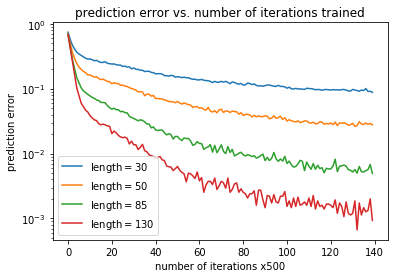

In [168]:
for i in [29, 49, 84, 129]:
    plt.plot([1-a[i] for a in meta.accuracy], label=f"length$={i+1}$")
plt.yscale("log")
plt.title("prediction error vs. number of iterations trained")
plt.xlabel("number of iterations x500")
plt.ylabel("prediction error")
plt.legend()
plt.show()

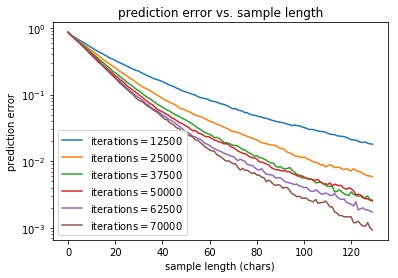

In [169]:
for i in range(24, len(meta.accuracy), 25):
    plt.plot(1.0-meta.accuracy[i], label=f"iterations$={500*(i+1)}$")
plt.plot(1.0-meta.accuracy[-1], label=f"iterations$={500*len(meta.accuracy)}$")
plt.yscale("log")
plt.title("prediction error vs. sample length")
plt.xlabel("sample length (chars)")
plt.ylabel("prediction error")
plt.legend()
plt.show()

In [81]:
import csv
with open("./europarl.test", "r") as f:
    reader = csv.reader(f, delimiter="\t")
    reader = [*reader]


In [155]:

count = len(reader)
correct = 0
errors = []
random.shuffle(reader)
print(len(reader))
for i, (lab, text) in enumerate(reader):
    p = m.predict(text[:127])
    p = m.data.languages[np.argmax(p)]
    correct = correct + (lab == p[-2:])
    if lab != p[-2:]:
        errors.append((p[-2:], lab, text))
    if i % 100 == 99:
        print("\r iteration:", i+1, "with accuracy:", correct / (i + 1), end="")

20828
 iteration: 20800 with accuracy: 0.99375

In [156]:
print("correctly predicted", correct, "out of", count, "samples: "
      "{0:.2f}% accuracy.".format(100 * correct / count))

correctly predicted 20698 out of 20828 samples: 99.38% accuracy.


In [165]:
for pred, lab, text in errors:
    print(" (", lab, ") ", text)

 ( cs )  Jmenovali se William Meyer, Bernard Starie, Reginald Pike, Thomas Shaw, James McLeish, Archibald Barrowman a Albert Roberts a všichni budou v sobotu vyznamenáni.
 ( lv )  Apsveicu, Pagano kundze.
 ( sk )  Ako ostatní, aj ja si myslím, že toto je základ a nie koniec.
 ( ro )  Votul va avea loc azi la ora 12.
 ( nl )  Water is echter niet gratis.
 ( fr )  Je terminerai cependant sur un appel.
 ( nl )  Ik noem nog enkele belangrijke regionale uitdagingen.
 ( pt )  Relatório Thyssen (A4-0137/99)
 ( es )  Es responsabilidad nuestra evitar esto.
 ( sk )  Rozsudok histórie je zrejmý.
 ( pl )  Obecnie tekst brzmi:
 ( sk )  Hlasovanie sa uskutoční v stredu.
 ( nl )  Dit instrument is in dit opzicht dus volledig tekortgeschoten.
 ( fr )  Y a-t-il des observations?
 ( es )  Son declaraciones sin ambigüedades.
 ( sk )  Táto správa je vyvážená a stanovuje hlavné geostrategické výzvy Južného Kaukazu.
 ( cs )  Bianco šek pro budoucnost, která zpráva požaduje, nelze brát vážně.
 ( es )  Con e

In [57]:
p = m.predict("All feelings that concentrate you and lift you up " 
              "are pure; only that feeling is impure which grasps "
              "just one side of your being and thus distorts you. "
                                            "- rainer maria rilke")
m.data.languages[np.argmax(p)]

'./text/en'